#### The purpose of this notebook is to:
    1. Import images of grids of solar panels from ./Data/170725_Panel_Grids_EL2.zip
    2. Perform a global histogram equalization.
    3. Determine the grid's outer perimeter.
    4. Deskew and center the grid.
    5. Detect vertical and horizontal lagunas between the panels.
    6. Use the results to crop and save each panel.
    7. Save the results to a directory in ./Data, providing a unique identifier for each panel.

In [93]:
from zipfile import ZipFile
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage.transform import rotate
from skimage.exposure import equalize_hist
from skimage.filters import threshold_otsu
%matplotlib inline

##### 1. Import panel grid.

In [94]:
# Hough transform
# Define a range of angles, radii
# For each angle, define a vector (cos(theta), sin(theta))

# Iterate over image. At each pixel;
#   > Form a vector (x, y)
#   > Take the dot product of this vector with all angles. (Result is point projection distance from center)
#   > Add to bins

# We can do the above simultaneously:
#  > Form a matrix C of coordinates (x, y) for all pixels.
#  > Let the Hough vector be u = (cos(theta), sin(theta)).
#  > Drop all zero pixels to form C'.
#  > Compute C'u = r, where r is a vector of project distances from the origin

# We can generalize the above further by letting U = [u1, u2, ..., un] where n is the number of angular bins.
# Then: C'U = R, such that R = [r1, r2, ..., rn] where ri is a vector of projection distances at angle i.

class HoughTransform(object):
    def __init__(self, angles, radii_bins):
        self.angles = angles
        self.radii_bins  = radii_bins
        self.H = None
    
    def transform(self, binary_image):
        """
            angles in angle_bins are in radians
            radii in radii bins are in image coordinates (origin at center of image frame)

            Configures HoughTransform's 'H' attribute.
            Configures HoughTransform's 'magnitude' attribute.
        """
        # Define basis vectors at defined angular spacing
        U = np.array([np.cos(self.angles), np.sin(self.angles)])
        # ^ Columns are u1, ..., where ui = (cos(theta_i), sin(theta_i))

        # Get cartesian position of non-zero image elements
        C       = np.array(np.nonzero(binary_image), dtype=np.float32) # i, j indices
        C[0, :] = (binary_image.shape[0]/2 - C[0, :])
        C[1, :] = (binary_image.shape[1]/2 - C[1, :])
        C       = np.flip(C, axis = 0) # (y, x) -> (x, y)

        # Project the non-zero elements onto the basis vectors
        R = np.matmul(C.T, U) # R = [r1, ..., rn] where ri is a vector of projection distances at angle i

        # Bin the values in R's columns at the specfied radii
        self.H = np.zeros(shape = [self.radii_bins.shape[0],
                                   self.angles.shape[0]]) # Columns correspond to angles, rows to specfied radii
        for i, radius_i in enumerate(self.radii_bins[:-1]):
                self.H[i, :] = np.sum(np.logical_and(R >= radius_i,
                                                     R < self.radii_bins[i+1]), axis = 0)
        
        # Get radius, angle of strongest response
        peak_ix          = np.nonzero(self.H == np.max(self.H))
        self.peak_angle  = self.angles[peak_ix[1][0]]
        self.peak_radius = self.radii_bins[peak_ix[0][0]]

In [95]:
def display_image(img):
    """
    Plots a single image, without axes.
    
    Arguments
        img is a 2D np.float32 array
    """
    f = plt.figure(figsize = (15, 7))
    plt.imshow(img, cmap = 'gray');
    return plt.gca()

In [286]:
def deskew_and_center(image):
    """
    Deskews and centers a grid of solar panel images.
    
    1. Inverts and thresholds image.
    2. Determines suitable parameters for a Hough transform. (distance from edge, range of angles)
    3. Applies the Hough transform in each direction (N, E, S, W).
    4. Identifies the angle + radial distance that yield a peak.
    5. Aligns the image frame's and grid rectangle's centers.
    6. Rotates the grid.
    
    Sub-functions:
    
    Arguments:
        img is a 2D np.float32 array of a grid of solar panels
    """
    
    # 0. Equalize the image (i.e. stretch its intensity distribution)
    image = equalize_hist(image) # in [0, 1]
    
    # 1. Invert and threshold the image.
    THRESHOLD = 0.4
    image  = image < THRESHOLD
    
    # 2. Determine suitable parameters for a Hough transform.
    if image.shape[0] < image.shape[1]:
        image = image.T
    
    # 3. Perform Hough transform (determines bounding perimeter rectangle lines)
    edge_parameters = {'N':[], 'E':[], 'S':[], 'W':[]}
    OFFSET          = {'N':[np.pi/2,  0.5*23*image.shape[0]/24, 0.5*image.shape[0]],
                       'E':[0,        0.5*11*image.shape[1]/12, 0.5*image.shape[1]],
                       'S':[-np.pi/2, 0.5*23*image.shape[0]/24, 0.5*image.shape[0]],
                       'W':[np.pi,    0.5*11*image.shape[1]/12, 0.5*image.shape[1]]}
    # ^ Angular offset, radii lower bound, radii upper bound
    ANGLE_RNG  = np.pi/20      # Max angle amplitude
    ANGLE_RES  = 0.2*ANGLE_RNG # Angular resolution
    
    for edge_key in edge_parameters.keys():
        angles     = np.arange(-ANGLE_RNG + OFFSET[edge_key][0], ANGLE_RNG + OFFSET[edge_key][0], ANGLE_RES)
        radii_bins = np.arange(OFFSET[edge_key][1], OFFSET[edge_key][2], 1)
        ht         = HoughTransform(angles, radii_bins)
        ht.transform(image)
        edge_parameters[edge_key] = (ht.peak_angle, ht.peak_radius)
    
    # 4.1. Center the grid
    delta_y = (edge_parameters['N'][1] - edge_parameters['S'][1])/2
    delta_x = (edge_parameters['E'][1] - edge_parameters['W'][1])/2
    image = np.roll(image, shift = int(delta_x), axis = 1)
    image = np.roll(image, shift = int(delta_y), axis = 0)
    
    # 4.2. Align the grid
    # Take median angle
    th    = np.median([edge_parameters['N'][0] - np.pi/2,
                       edge_parameters['E'][0] - 0,
                       edge_parameters['S'][0] + np.pi/2,
                       edge_parameters['W'][0] - np.pi])
    image = rotate(image, -th) # Rotates in counter-clockwise direction - we want to *correct* the skew
    
    return image

In [295]:
def peak_detector(score, threshold):
    """
        Returns indices corresponding to cluster centers in a 1D series.
        Smooths, thresholds, retrieves centroids of sets of contiguous elements.
    """
    SD        = 5
    score     = gaussian_filter(score, sigma = SD) > threshold
    n_points_in_cluster = 0
    index_sum = 0
    cluster_centroids = []
    
    for i in range(score.shape[0]):
        if (score[i] == 1):
            index_sum += i
            n_points_in_cluster += 1
            
        if ((score[i] == 0) or (i+1 == score.shape[0])) and (n_points_in_cluster > 0):
            cluster_centroids.append(int(index_sum/n_points_in_cluster))
            index_sum = 0
            n_points_in_cluster = 0
            
    return np.array(cluster_centroids)

In [347]:
counter = 0
k = 5

_ = True
with ZipFile('./Data/170725_Panel_Grids_EL2.zip', mode = 'r') as grid_archive:
    for filename in grid_archive.infolist():
        with grid_archive.open(filename) as file:
            counter += 1
            if counter == k:
                img = Image.open(file).convert('L')
                img = np.array(img.getdata()).reshape(img.size[1], img.size[0]).astype(np.float32)

                # De-skew and center the grid of panels (Apply Hough then affine transform)
                deskewed_img = deskew_and_center(img)

                # Sum over either axis to get line scores
                GAMMA_H = 1/0.991
                GAMMA_V = 1/0.996
                
                horizontal_line_score = np.prod(GAMMA_H**(deskewed_img - 1), axis = 1)
                vertical_line_score   = np.prod(GAMMA_V**(deskewed_img - 1), axis = 0)

                # Get row indices and column indices corresponding to panel edges from line scores
                row_ix = peak_detector(horizontal_line_score, 0.025) # Row indices
                col_ix = peak_detector(vertical_line_score, 0.07)   # Column indices

                # Calculate number of panels in image
                n_panels = (row_ix.shape[0] - 1) * (col_ix.shape[0] - 1)
                panels   = []

                for i in range(row_ix.shape[0]-1):
                    for j in range(col_ix.shape[0]-1):
                        panels.append(img[row_ix[i]:row_ix[i+1],
                                          col_ix[j]:col_ix[j+1]])
            
        if counter == k: break

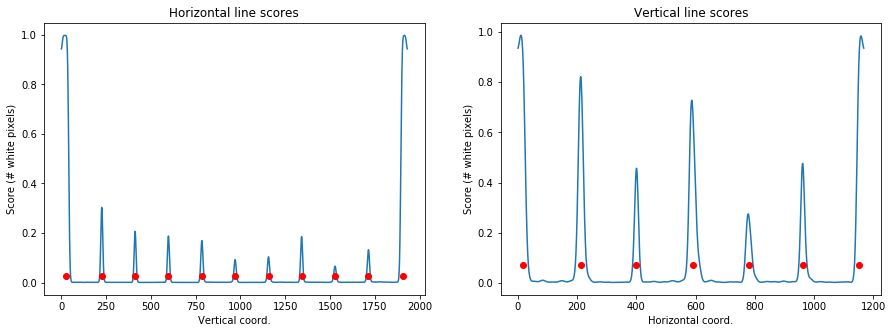

In [348]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))

h_peak_ix = peak_detector(horizontal_line_score, 0.025)
v_peak_ix = peak_detector(vertical_line_score, 0.07)

axs[0].plot(np.arange(img.shape[0]), gaussian_filter(horizontal_line_score, sigma = 5))
axs[0].plot(h_peak_ix,
            [0.025]*h_peak_ix.shape[0],
            'ro')
axs[0].set_title('Horizontal line scores'); axs[0].set_xlabel('Vertical coord.'); axs[0].set_ylabel('Score (# white pixels)');
axs[0].plot()

axs[1].plot(np.arange(img.shape[1]), gaussian_filter(vertical_line_score, sigma = 5))
axs[1].plot(v_peak_ix,
            [0.07]*v_peak_ix.shape[0],
            'ro')
axs[1].set_title('Vertical line scores'); axs[1].set_xlabel('Horizontal coord.'); axs[1].set_ylabel('Score (# white pixels)');

#plt.savefig('panel_extractor_line_scoring.pdf')

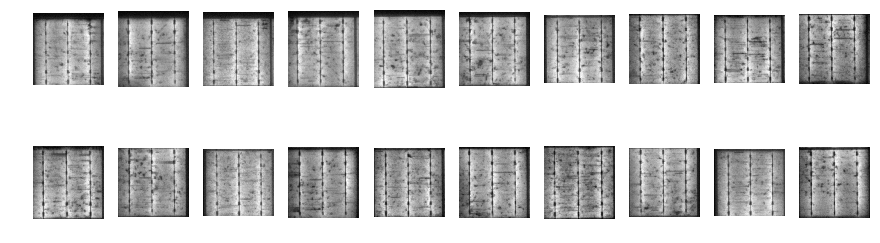

In [349]:
f, axs = plt.subplots(2, 10, figsize = (15, 4.5))
for i, ax in enumerate(axs.flat):
    ax.imshow(panels[i], cmap = 'gray');
    ax.axis('off');